# Model calibration and differentiable histograms

In this example, we want to find the offsets and tilts of the quadrupoles in a beamline given the 2D beam profile downstream.
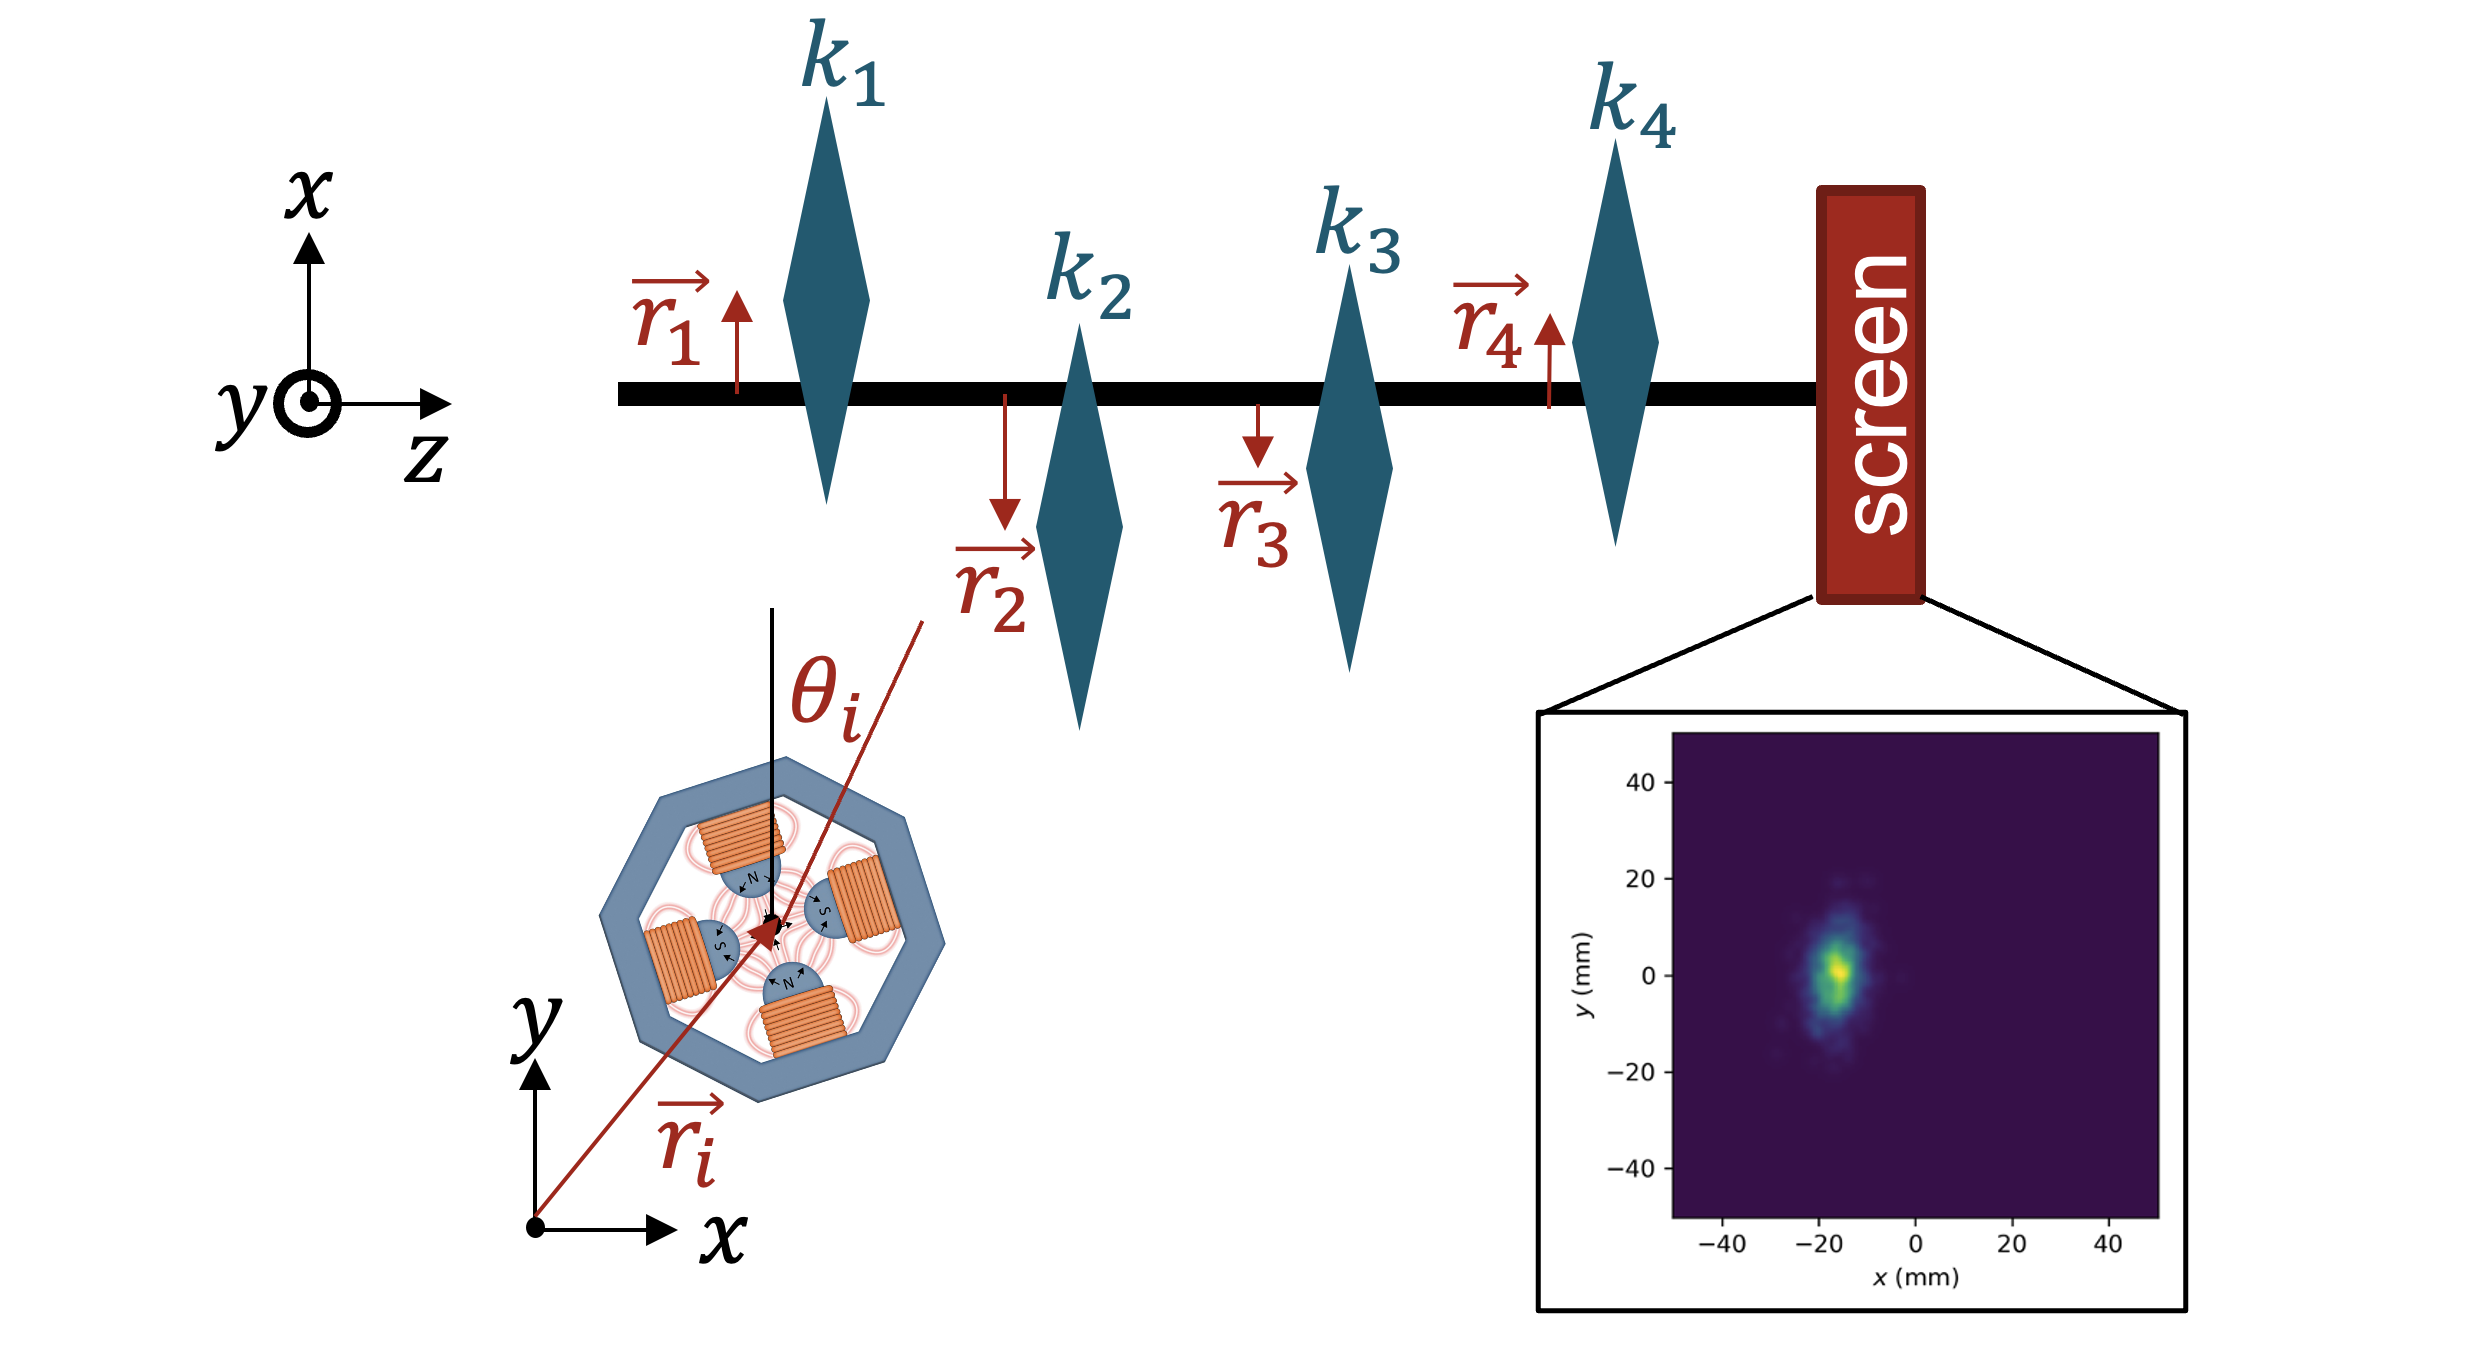

In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt

from bmadx import Particle, Quadrupole, Drift
from bmadx import track_lattice, track_lattice_save_stats
from bmadx import M_ELECTRON

import time
from kornia.enhance.histogram import histogram2d
tkwargs = {
    "dtype" : torch.double
}
np.set_printoptions(precision=16, suppress=False)
torch.set_printoptions(precision=16, sci_mode=True)
torch.__version__, np.__version__
%config InlineBackend.figure_format = 'retina'

In [2]:
# random ground truth offsets:
torch.manual_seed(0)
offsets_x_true = torch.normal(mean=0, std=1e-2, size=(4,), **tkwargs)
offsets_y_true = torch.normal(mean=0, std=1e-2, size=(4,), **tkwargs)
tilts_true = torch.normal(mean=0, std=1e-1, size=(4,), **tkwargs)
offsets_x_true, offsets_y_true, tilts_true

(tensor([1.5409961082440433e-02, -2.9342890576094637e-03, -2.1787893820745575e-02,
         5.6843127728066776e-03], dtype=torch.float64),
 tensor([-1.0845223424240210e-02, -1.3985953953708767e-02, 4.0334684762929930e-03,
         8.3802633299765988e-03], dtype=torch.float64),
 tensor([-7.1925757846935931e-02, -4.0334352493217457e-02, -5.9663536261512731e-02,
         1.8203648506130553e-02], dtype=torch.float64))

## Finding resonable quad strengths
Let's start by finding a reasonable set of quadrupole strengths by minimizing the difference of the incoming and outgoing beam moments

In [3]:
# Initial beam distribution

s = torch.tensor(0.0, **tkwargs)
p0c = torch.tensor(4.0e7, **tkwargs) # Reference particle momentum in eV

sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([9e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
coords = dist.sample(torch.Size([sample_size]))

p_in = Particle(*coords.T, s, p0c, M_ELECTRON)

In [4]:
# Lattice fixed parameters
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length

# Define function to create lattice
def create_lattice(k1s, l_d, l_q, offsets_x, offsets_y, tilts):
    """Creates lattice with len(k1s) quadrupoles separated by drifts.
    k1s, offsets_x, offsets_y and tilts are the quadrupole parameters.
    """
    half_drift = Drift(l_d/2)
    lattice=[]
    for i in range(len(k1s)):
        lattice.append( half_drift )
        lattice.append( Quadrupole(L=l_q, K1=k1s[i],
                                   X_OFFSET=offsets_x[i],
                                   Y_OFFSET=offsets_y[i],
                                   TILT=tilts[i]))
        lattice.append( half_drift )
    return lattice

# Beamline Model to get reasonable quad strengths
class QuadModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s, l_d, l_q, offsets_x, offsets_y, tilts):
        super().__init__()
        self.register_parameter('k1s', torch.nn.Parameter(k1s))
        self.l_d = l_d
        self.l_q = l_q
        self.offsets_x = offsets_x
        self.offsets_y = offsets_y
        self.tilts = tilts
        
    def forward(self):
        # build lattice:
        lattice = create_lattice(self.k1s, self.l_d, self.l_q, self.offsets_x, self.offsets_y, self.tilts)
        
        # outgoing particle: 
        p_out = track_lattice(p_in, lattice)
        
        # return loss
        return torch.sqrt((torch.std(p_out.x)-torch.std(p_in.x))**2+(torch.std(p_out.y)-torch.std(p_in.y))**2
                          +(torch.std(p_out.px)-torch.std(p_in.px))**2+(torch.std(p_out.py)-torch.std(p_in.py))**2)

In [5]:
# Training function
def train_k1s_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter # list to save params
    history_loss = [None] * training_iter # list to save loss
    
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use PyTorch Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward() # gradient
        
        # print info:
        if i%100==0: #print each 100 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()*1e6
            ))
        
        # save loss and param
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        
        # optimization step
        optimizer.step()
    
    # returns params and loss for every iteration
    return np.asarray(history_param), np.asarray(history_loss)

In [6]:
%%time
# Initial k1s
k1s = torch.zeros(4, **tkwargs)

# Optimization
model = QuadModel(k1s, L_d, L_q, offsets_x_true, offsets_y_true, tilts_true)
params, loss = train_k1s_model(model, 5000, 0.01)

k1s : Parameter containing:
tensor([0., 0., 0., 0.], dtype=torch.float64, requires_grad=True)
Iter 1/5000 - Loss: 6516.91113 
Iter 101/5000 - Loss: 6203.64882 
Iter 201/5000 - Loss: 5852.43537 
Iter 301/5000 - Loss: 5391.74885 
Iter 401/5000 - Loss: 4815.54838 
Iter 501/5000 - Loss: 3947.82285 
Iter 601/5000 - Loss: 2679.62370 
Iter 701/5000 - Loss: 1578.88841 
Iter 801/5000 - Loss: 799.28799 
Iter 901/5000 - Loss: 502.53666 
Iter 1001/5000 - Loss: 488.96515 
Iter 1101/5000 - Loss: 481.24143 
Iter 1201/5000 - Loss: 472.72547 
Iter 1301/5000 - Loss: 463.51695 
Iter 1401/5000 - Loss: 453.73446 
Iter 1501/5000 - Loss: 443.51956 
Iter 1601/5000 - Loss: 433.03785 
Iter 1701/5000 - Loss: 422.47627 
Iter 1801/5000 - Loss: 412.03636 
Iter 1901/5000 - Loss: 401.92387 
Iter 2001/5000 - Loss: 392.33576 
Iter 2101/5000 - Loss: 383.44664 
Iter 2201/5000 - Loss: 375.39646 
Iter 2301/5000 - Loss: 368.28152 
Iter 2401/5000 - Loss: 362.15010 
Iter 2501/5000 - Loss: 357.00281 
Iter 2601/5000 - Loss: 352

Text(0, 0.5, 'loss $\\sqrt{\\Delta_x^2 + \\Delta_{p_x}^2 + \\Delta_y^2 + \\Delta_{p_y}^2}$')

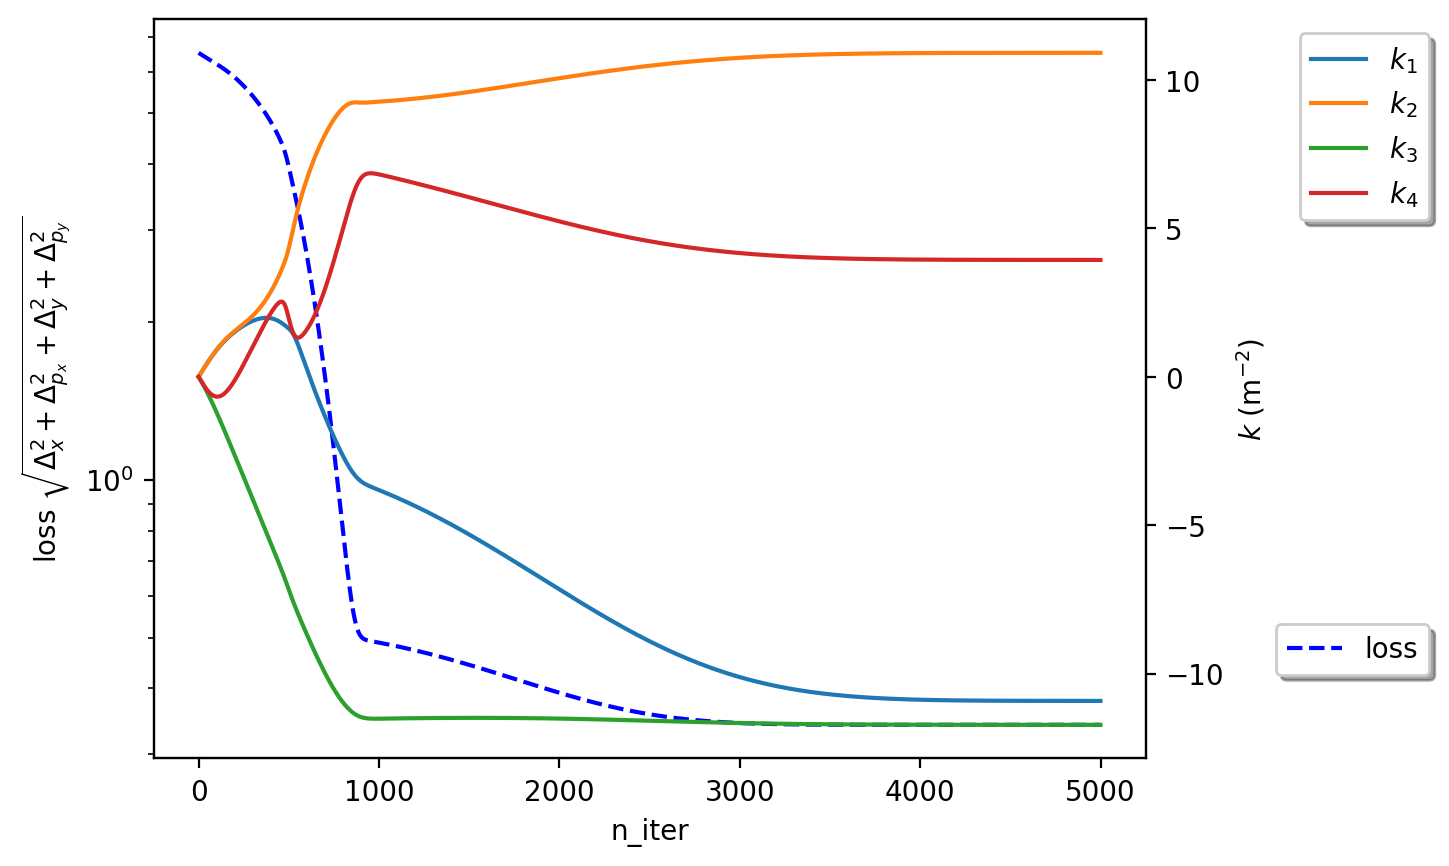

In [7]:
# Plot loss and parameters as function of iteration number
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(k1s)):
    ax2.plot(np.arange(len(params[:,0])), params[:,i], label=f'$k_{{{i+1}}}$')
ax1.plot(np.arange(len(loss)), loss*1000, '--b', label='loss')
ax1.set_yscale('log')                
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1, fancybox=True, shadow=True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 0.2), ncol=1, fancybox=True, shadow=True)
ax1.set_xlabel('n_iter')
ax2.set_ylabel(r'$k$ (m$ ^{-2}$)')
ax1.set_ylabel(r'loss $\sqrt{\Delta_x^2 + \Delta_{p_x}^2 + \Delta_y^2 + \Delta_{p_y}^2}$')

In [8]:
k1s_opt = params[-1]
k1s_opt

array([-10.921858140417122 ,  10.920127531076096 , -11.728519141626995 ,
         3.9409836121981794])

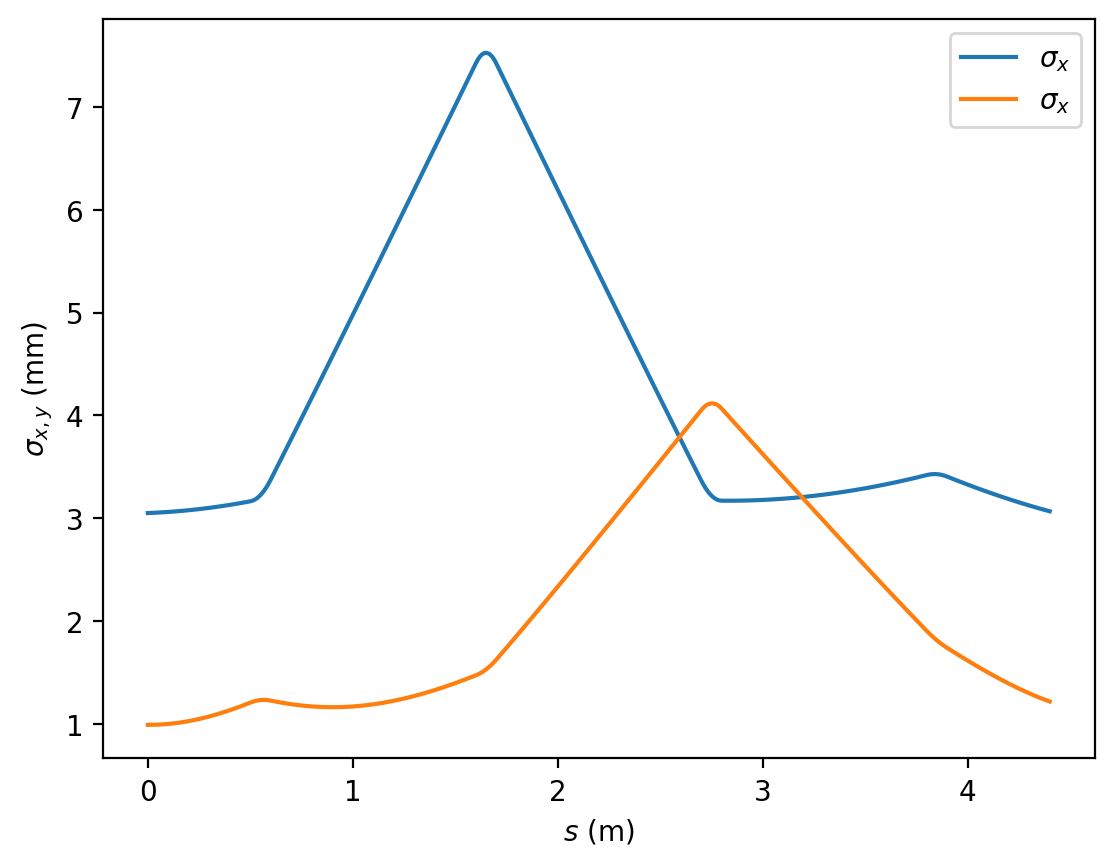

In [9]:
# plot beamsize vs s for optimal configuration
lattice = create_lattice(k1s_opt, L_d, L_q, offsets_x_true, offsets_y_true, tilts_true)

stats = track_lattice_save_stats(p_in, lattice, n_slices=10)

plt.plot(stats['s'], np.array(stats['sigma_x'])*1000, label=r'$\sigma_x$')
plt.plot(stats['s'], np.array(stats['sigma_y'])*1000, label=r'$\sigma_x$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

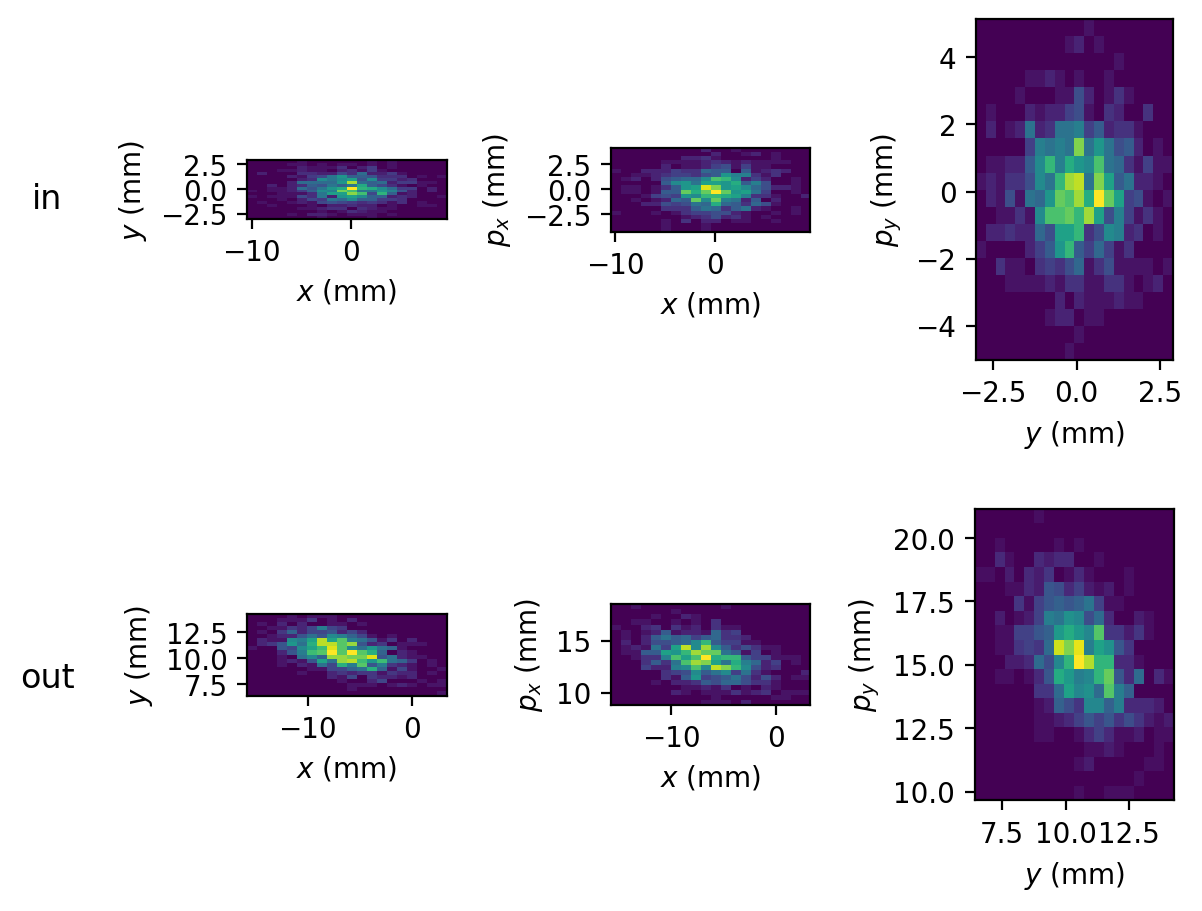

In [10]:
# plot initial and final beam distributions
p_out = stats['p_out']
fig, ax = plt.subplots(2,3)
for i in range(2):
    if i == 0:
        par = p_in
    else:
        par = p_out
    ax[i,0].hist2d(par.x.numpy()*1e3, par.y.numpy()*1e3, bins=20)
    ax[i,0].set_aspect('equal')
    ax[i,0].set_xlabel(r'$x$ (mm)')
    ax[i,0].set_ylabel(r'$y$ (mm)')
    ax[i,1].hist2d(par.x.numpy()*1e3, par.px.numpy()*1e3, bins=20)
    ax[i,1].set_xlabel(r'$x$ (mm)')
    ax[i,1].set_ylabel(r'$p_x$ (mm)')
    ax[i,1].set_aspect('equal')
    ax[i,2].hist2d(par.y.numpy()*1e3, par.py.numpy()*1e3, bins=20)
    ax[i,2].set_xlabel(r'$y$ (mm)')
    ax[i,2].set_ylabel(r'$p_y$ (mm)')
    ax[i,2].set_aspect('equal')
ax[0,0].set_title('in', x=-1, y=-0.1)
ax[1,0].set_title('out', x=-1, y=-0.1) 
plt.tight_layout()

## Scan over quad strengths
Now that we have some reasonable quad strenghts, we can measure the beam profile for quad strengths nearby. Let's increase and decrease each quad strength independently by some amount epsilon. Since we have 4 quadrupoles, we will have 8 different sets of ${k_i}$

In [11]:
# k1s used to get offsets. Each quadrupole strength is increased once from the optimal configuration. 
epsilon = 0.3 # quad strength change
k1s_tests = []
for i in range(8):
    k1s_tests.append(k1s_opt.copy())
    
k1s_tests[0][0]=k1s_opt[0]*(1+epsilon)
k1s_tests[1][0]=k1s_opt[0]*(1-epsilon)
k1s_tests[2][1]=k1s_opt[1]*(1+epsilon)
k1s_tests[3][1]=k1s_opt[1]*(1-epsilon)
k1s_tests[4][2]=k1s_opt[2]*(1+epsilon)
k1s_tests[5][2]=k1s_opt[2]*(1-epsilon)
k1s_tests[6][3]=k1s_opt[3]*(1+epsilon)
k1s_tests[7][3]=k1s_opt[3]*(1-epsilon)

k1s_tests

[array([-14.198415582542259 ,  10.920127531076096 , -11.728519141626995 ,
          3.9409836121981794]),
 array([ -7.645300698291985 ,  10.920127531076096 , -11.728519141626995 ,
          3.9409836121981794]),
 array([-10.921858140417122 ,  14.196165790398926 , -11.728519141626995 ,
          3.9409836121981794]),
 array([-10.921858140417122 ,   7.644089271753266 , -11.728519141626995 ,
          3.9409836121981794]),
 array([-10.921858140417122 ,  10.920127531076096 , -15.247074884115094 ,
          3.9409836121981794]),
 array([-10.921858140417122 ,  10.920127531076096 ,  -8.209963399138896 ,
          3.9409836121981794]),
 array([-10.921858140417122,  10.920127531076096, -11.728519141626995,
          5.123278695857634]),
 array([-10.921858140417122 ,  10.920127531076096 , -11.728519141626995 ,
          2.7586885285387255])]

In [12]:
# outgoing bunch with true offsets for each set of k1s
p_out_tests = []
p_out_tests_no_offsets = []
for test in range(len(k1s_tests)):
    k1s = k1s_tests[test]
    lattice_offsets = create_lattice(k1s, L_d, L_q, offsets_x_true, offsets_y_true, tilts_true)
    p_out_tests.append( track_lattice(p_in, lattice_offsets) )
    # outgoing particles with no offsets (for comparison purposes)
    lattice_no_offsets = create_lattice(k1s, L_d, L_q, torch.zeros(4), torch.zeros(4), torch.zeros(4))
    p_out_tests_no_offsets.append( track_lattice(p_in, lattice_no_offsets) )

## Differentiable histograms using kernel density estimation (KDE)
We need a differentiable version of the histogram. For that, we can use KDE from the Kornia package, which works with PyTorch tensors.

In [13]:
# screen parameters
n_bins = 200
lim = 50e-3 # limits in [m]
edges = torch.linspace(-lim, lim, n_bins, **tkwargs)
xx = torch.meshgrid((edges, edges), indexing='ij')

In [14]:
# differentiable transverse histogram version of p_out_tests
p_out_test_hist = []
for test in range(len(k1s_tests)):
    p_out_test_hist.append( histogram2d(
        p_out_tests[test].x.unsqueeze(0),
        p_out_tests[test].y.unsqueeze(0),
        edges, 
        bandwidth = torch.tensor(1e-3)  
    ) )
    p_out_test_hist[test] = p_out_test_hist[test] + histogram2d(
        p_out_tests[test].x.unsqueeze(0),
        p_out_tests[test].y.unsqueeze(0),
        edges, 
        bandwidth = torch.tensor(1e-1)  
    )

Text(0.5, 1.0, 'out (no offsets/tilts)')

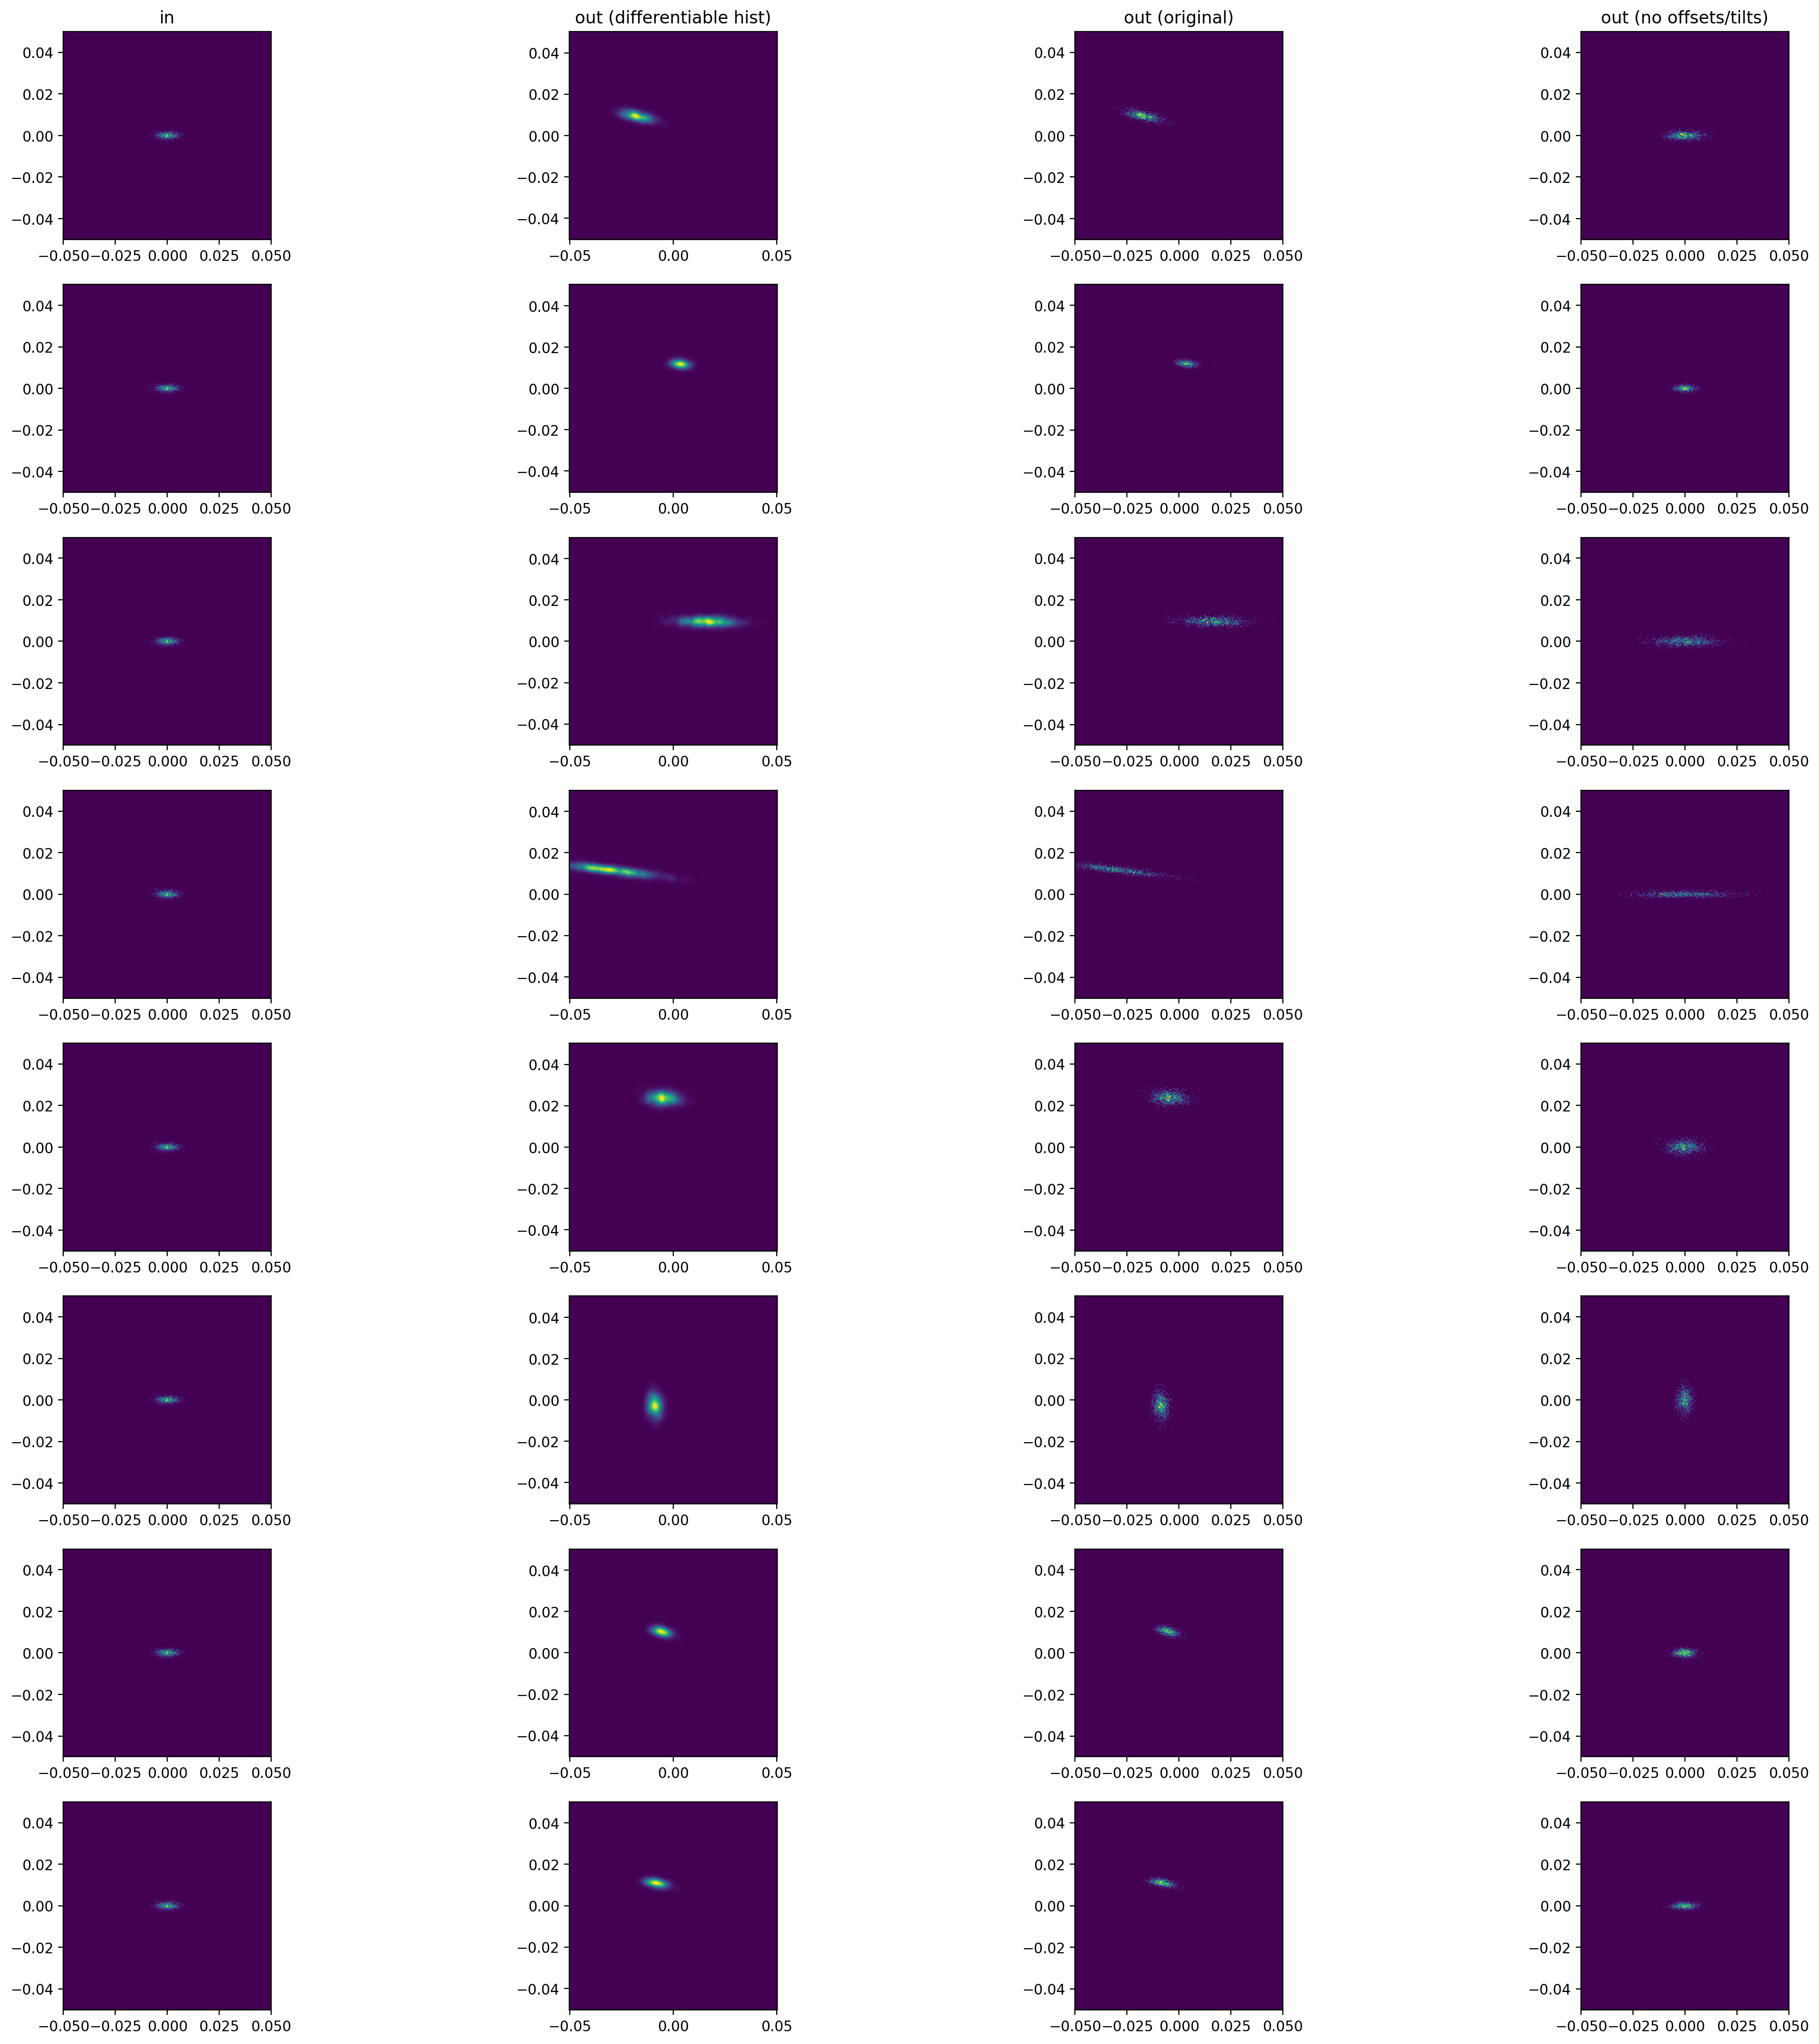

In [15]:
# plot in and out beams for each set of k1s

# incoming 2D beam profile
x_in = p_in.x.detach().numpy()
y_in = p_in.y.detach().numpy()

# outgoing 2D beam profiles
x_out = []
y_out = []
x_out_no_offsets = []
y_out_no_offsets = []
for test in range(len(k1s_tests)):
    x_out.append( p_out_tests[test].x.detach().numpy() )
    y_out.append( p_out_tests[test].y.detach().numpy() )
    x_out_no_offsets.append( p_out_tests_no_offsets[test].x.detach().numpy() )
    y_out_no_offsets.append( p_out_tests_no_offsets[test].y.detach().numpy() )

# figure
fig, ax = plt.subplots(len(k1s_tests),4, figsize=(20,20))
fig.tight_layout()
for test in range(len(k1s_tests)):
    ax[test,0].hist2d(x_in, y_in, bins=edges)
    ax[test,0].set_aspect('equal')
    #ax[test,0].set_title('in')
    ax[test,1].pcolor(*xx, p_out_test_hist[test].squeeze().detach())
    ax[test,1].set_aspect('equal')
    #ax[test,1].set_title('out (diff hist)')
    ax[test,2].hist2d(x_out[test],y_out[test], bins=edges)
    ax[test,2].set_aspect('equal')
    #ax[test,2].set_title('out (original)')
    ax[test,3].hist2d(x_out_no_offsets[test],y_out_no_offsets[test], bins=edges)
    ax[test,3].set_aspect('equal')
    #ax[test,3].set_title('out (no offsets)')
    
ax[0,0].set_title('in')
ax[0,1].set_title('out (differentiable hist)')
ax[0,2].set_title('out (original)')
ax[0,3].set_title('out (no offsets/tilts)')

## Finding offsets and tilts
Now we can find the offsets and tilts by minimizing the sum of KL divergences between the ground truth images and the simulated images.

In [16]:
# Define KL Divergence between true and simulated histograms
def KL_divergence(y_true, y_sim):
    return torch.sum(y_true * (y_true.log() - y_sim.log()))

In [17]:
def get_beam_profile_hist(k1s, l_d, l_q, offsets_x, offsets_y, tilts, bandwidth=torch.tensor(1e-3)):
    """Returns the differentiable beam profile histogram."""
    lattice = create_lattice(k1s, l_d, l_q, offsets_x, offsets_y, tilts)
    p_out = track_lattice(p_in, lattice)
    hist_pdf = histogram2d(
        p_out.x.unsqueeze(0),
        p_out.y.unsqueeze(0),
        edges,
        bandwidth=bandwidth)
    
    background = histogram2d(
        p_out.x.unsqueeze(0),
        p_out.y.unsqueeze(0),
        edges,
        bandwidth=torch.tensor(1e-1) )
    beam_profile_hist = hist_pdf + background
    return beam_profile_hist

Text(25.09722222222222, 0.5, '$y$ (mm)')

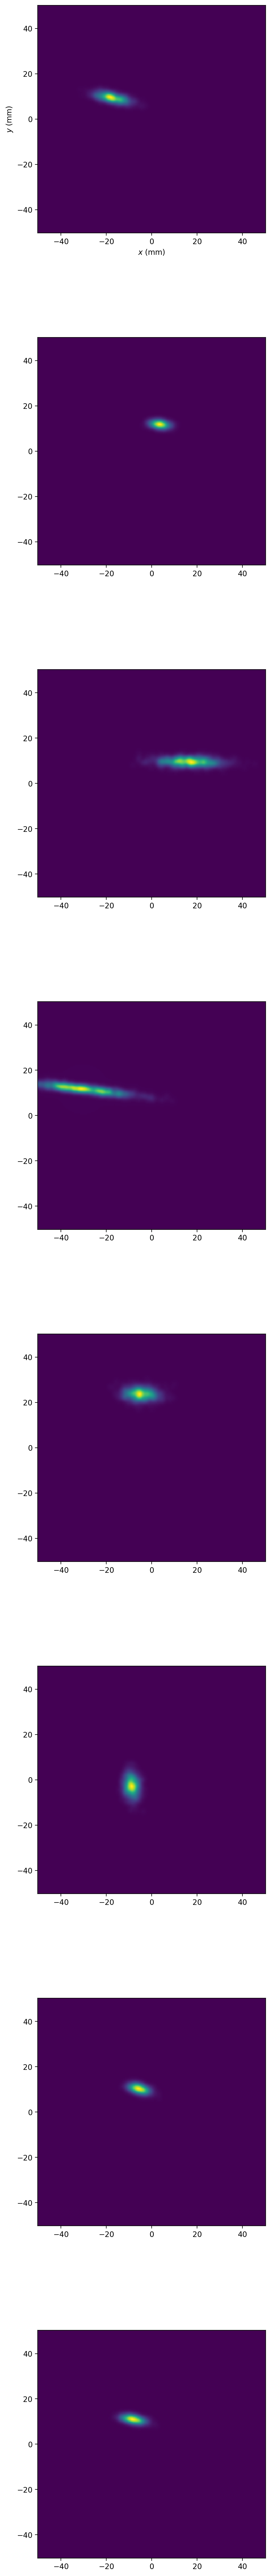

In [18]:
ground_truth_hist = []
for i in range(len(k1s_tests)):
    ground_truth_hist.append( get_beam_profile_hist(k1s_tests[i], L_d, L_q, offsets_x_true, offsets_y_true, tilts_true) )

# plot beam profile differentiable histograms
fig, ax = plt.subplots(len(k1s_tests), figsize=(5,50))
fig.tight_layout()
xx = torch.meshgrid((edges*1e3, edges*1e3), indexing='ij')
for test in range(len(k1s_tests)):
    ax[test].pcolor(*xx, ground_truth_hist[test].squeeze().detach()*1e3)
    ax[test].set_aspect('equal')
    #ax[test].set_title('offsets_hist')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')

In [19]:
# Beamline model to find offsets 
class OffsetModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s_tests, l_d, l_q, offsets_x, offsets_y, tilts):
        super().__init__()
        self.k1s_tests = k1s_tests
        self.l_d = l_d
        self.l_q = l_q
        self.register_parameter('offsets_x',torch.nn.Parameter(offsets_x))
        self.register_parameter('offsets_y',torch.nn.Parameter(offsets_y))
        self.register_parameter('tilts',torch.nn.Parameter(tilts))
    def forward(self):
        KL_sum=0
        for i in range(len(k1s_tests)):
            KL_sum+=KL_divergence(ground_truth_hist[i],
                                  get_beam_profile_hist(self.k1s_tests[i], self.l_d, self.l_q, self.offsets_x, self.offsets_y, self.tilts))
        return KL_sum

In [20]:
# Training function

def train_offset_model(model, training_iter, alpha=0.1):
    
    # print the trainable parameters
    n_parameters = 0
    for param in model.named_parameters():
        n_parameters+=1
        
    #history_param = [None] * training_iter
    history_params = np.zeros((training_iter, n_parameters, 4))
    history_loss = [None] * training_iter
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%100==0: #print each 10 steps
            print('Iter %d/%d - Loss*1e6: %.5f '% (
                i + 1, training_iter, loss.item()*1e6
            ))
        n=0
        for param in model.parameters():
            history_params[i,n,:] = param.data.detach().numpy().copy()
            n+=1
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        
    return history_params, np.asarray(history_loss)

In [21]:
%%time
# Optimization
model = OffsetModel(k1s_tests, L_d, L_q, torch.zeros(4), torch.zeros(4), torch.zeros(4))
params, loss = train_offset_model(model, 5000, 1e-3)

Iter 1/5000 - Loss*1e6: 34328336.14320 
Iter 101/5000 - Loss*1e6: 553483.10734 
Iter 201/5000 - Loss*1e6: 120582.91140 
Iter 301/5000 - Loss*1e6: 50435.55624 
Iter 401/5000 - Loss*1e6: 22617.15952 
Iter 501/5000 - Loss*1e6: 41271.08371 
Iter 601/5000 - Loss*1e6: 5273.80911 
Iter 701/5000 - Loss*1e6: 3879.79531 
Iter 801/5000 - Loss*1e6: 13010.82137 
Iter 901/5000 - Loss*1e6: 5333.69095 
Iter 1001/5000 - Loss*1e6: 60782.82221 
Iter 1101/5000 - Loss*1e6: 6779.73756 
Iter 1201/5000 - Loss*1e6: 92466.02019 
Iter 1301/5000 - Loss*1e6: 20843.36327 
Iter 1401/5000 - Loss*1e6: 4575.32412 
Iter 1501/5000 - Loss*1e6: 15732.26391 
Iter 1601/5000 - Loss*1e6: 74146.13341 
Iter 1701/5000 - Loss*1e6: 7610.13039 
Iter 1801/5000 - Loss*1e6: 6304.02361 
Iter 1901/5000 - Loss*1e6: 90892.29006 
Iter 2001/5000 - Loss*1e6: 27864.37510 
Iter 2101/5000 - Loss*1e6: 72502.16450 
Iter 2201/5000 - Loss*1e6: 27505.46599 
Iter 2301/5000 - Loss*1e6: 24378.52511 
Iter 2401/5000 - Loss*1e6: 65190.36470 
Iter 2501/5000

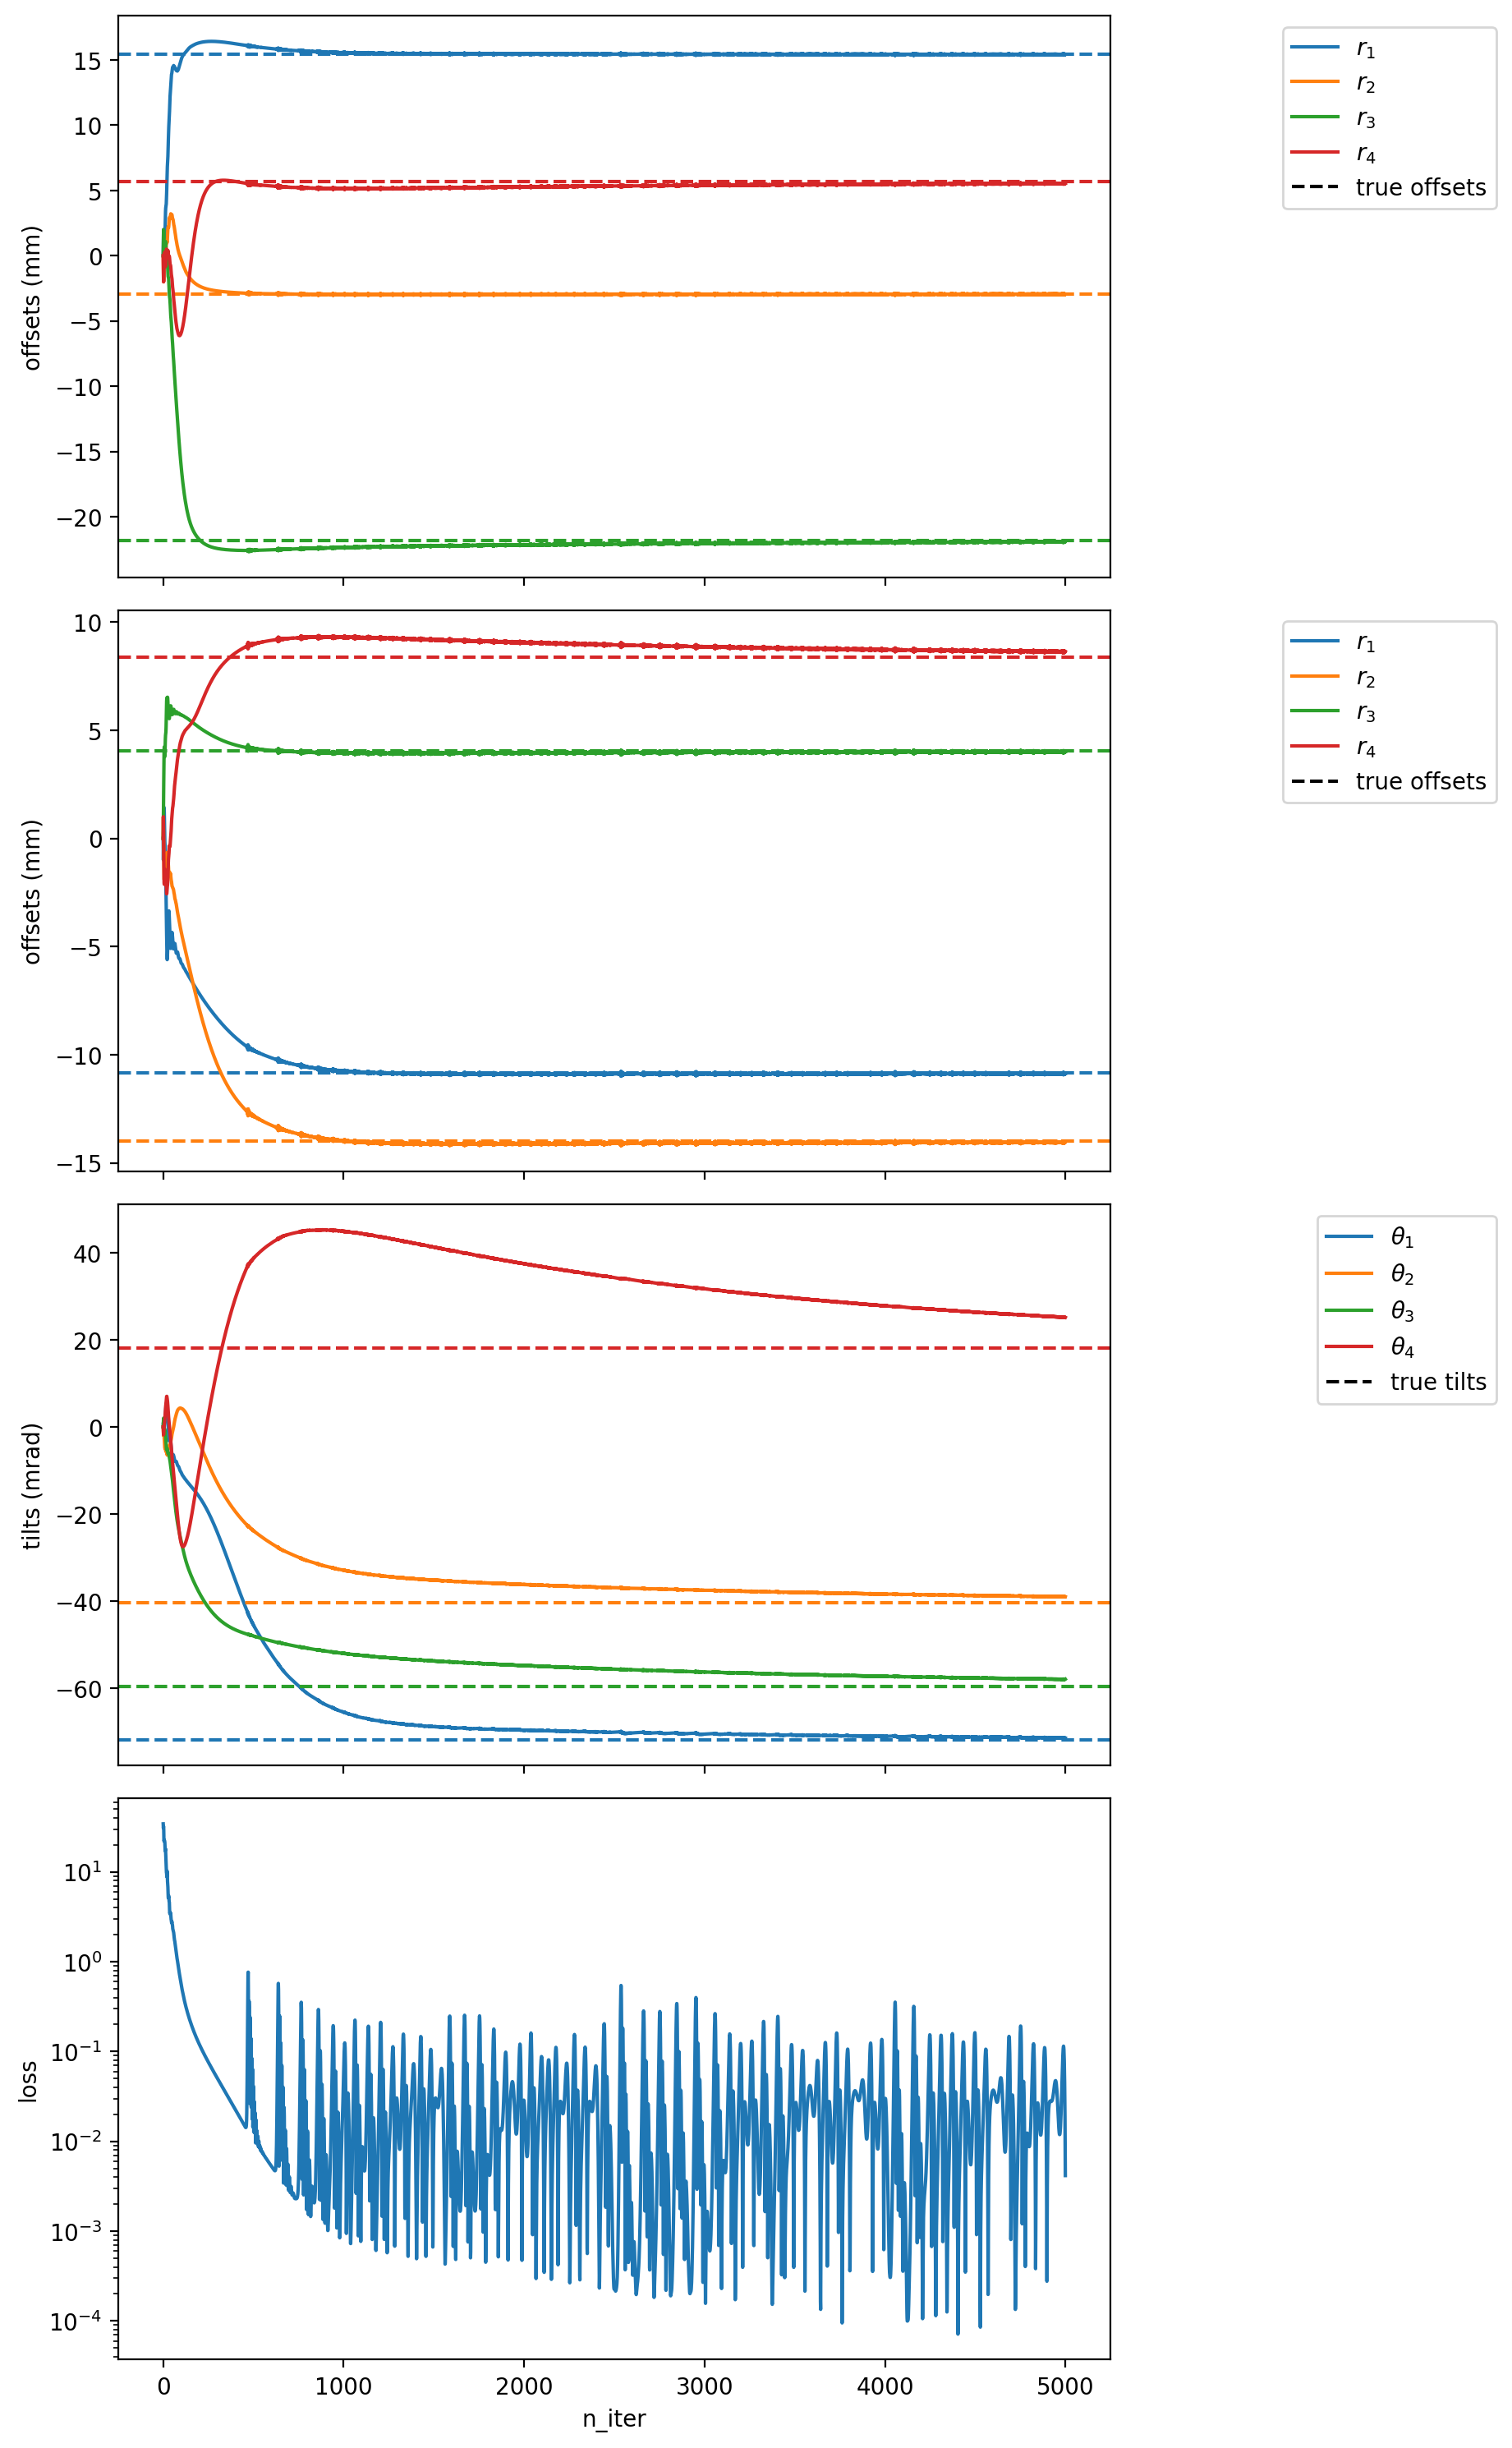

In [22]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#colors = ['blue', 'magenta', 'green']
fig, ax = plt.subplots(4,1, figsize=(10,15), sharex=True)
for i in range(len(k1s_opt)):
    ax[0].axhline(offsets_x_true[i]*1000, color=colors[i], linestyle="--")
    ax[0].plot(np.arange(len(params[:,0,0])), params[:,0,i]*1000, color=colors[i], label=fr'$r_{{{i+1}}}$')
    ax[1].axhline(offsets_y_true[i]*1000, color=colors[i], linestyle="--")
    ax[1].plot(np.arange(len(params[:,1,0])), params[:,1,i]*1000, color=colors[i], label=fr'$r_{{{i+1}}}$')
    ax[2].axhline(tilts_true[i]*1000, color=colors[i], linestyle="--")
    ax[2].plot(np.arange(len(params[:,2,0])), params[:,2,i]*1000, color=colors[i], label=fr'$\theta_{{{i+1}}}$')
ax[0].plot([0],[0], color='black', linestyle='--', label='true offsets')
ax[0].legend(loc='upper right', bbox_to_anchor=(1.4,1))
ax[0].set_ylabel(r'offsets (mm)')
ax[1].plot([0],[0], color='black', linestyle='--', label='true offsets')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.4,1))
ax[1].set_ylabel(r'offsets (mm)')
ax[2].plot([0],[0], color='black', linestyle='--', label='true tilts')
ax[2].legend(loc='upper right', bbox_to_anchor=(1.4,1))
ax[2].set_ylabel(r'tilts (mrad)')
#ax[0].set_xlabel('n_iter')
ax[3].plot(np.arange(len(loss)), (loss))
ax[3].set_yscale('log')
ax[3].set_ylabel('loss')
ax[3].set_xlabel('n_iter')
fig.tight_layout()

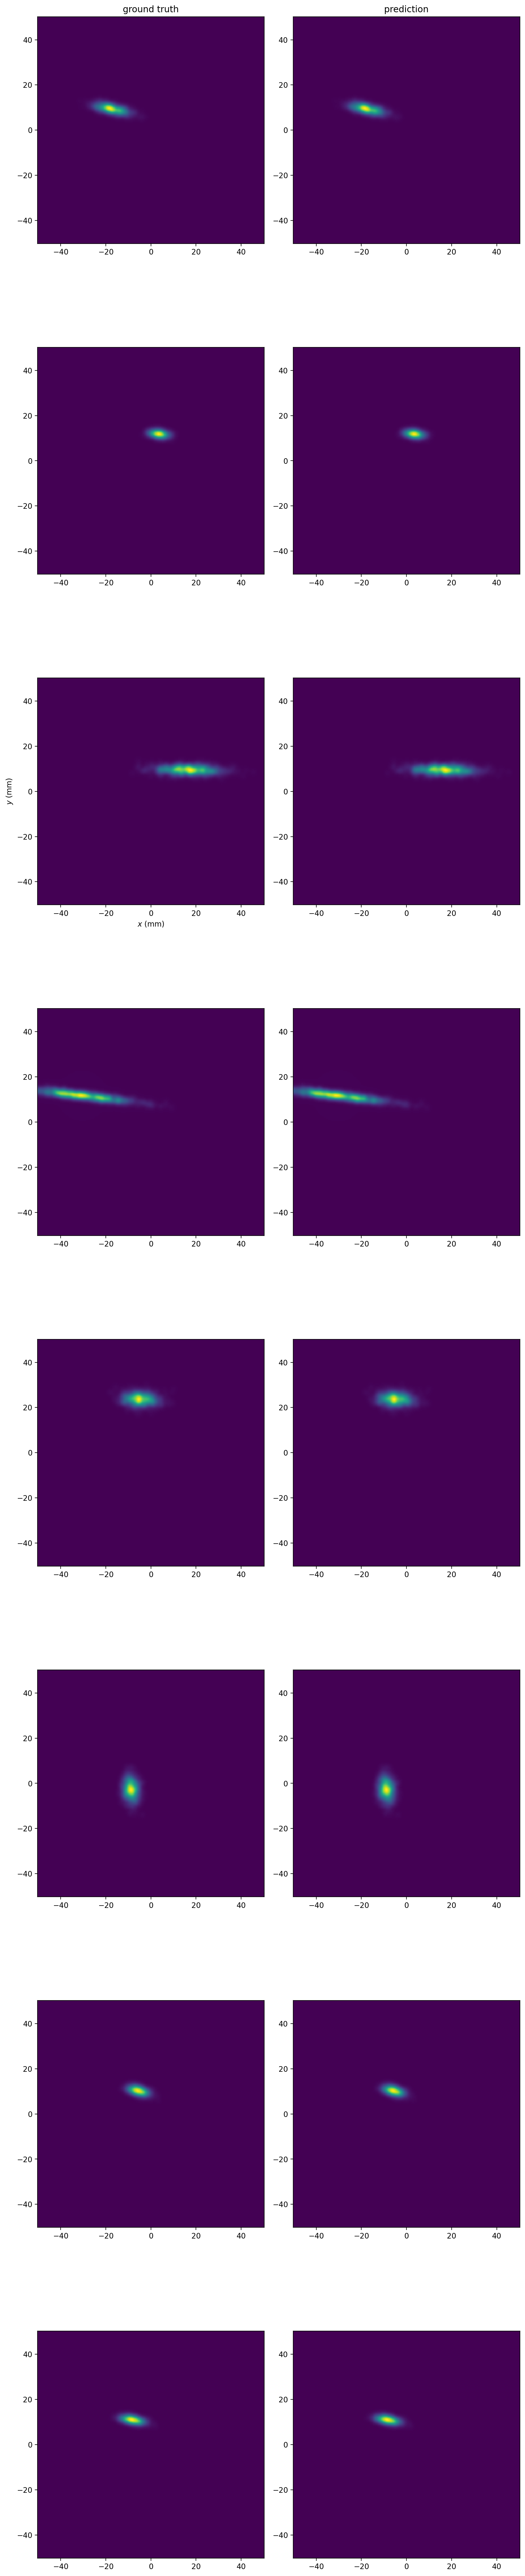

In [23]:
offsets_x_pred = torch.tensor(params[-1,0,:].copy(), **tkwargs)
offsets_y_pred = torch.tensor(params[-1,1,:].copy(), **tkwargs)
tilts_pred = torch.tensor(params[-1,2,:].copy(), **tkwargs)
a = [get_beam_profile_hist(k1s , L_d, L_q, offsets_x_pred, offsets_y_pred, tilts_pred) for k1s in k1s_tests]

xx = torch.meshgrid((edges*1e3, edges*1e3), indexing='ij')
num_tests = len(ground_truth_hist)
fig, ax = plt.subplots(num_tests,2, figsize=(10,50))

for i in range(num_tests):
    ax[i,0].pcolor(*xx, ground_truth_hist[i].squeeze().detach()*1e3)
    ax[i,0].set_aspect('equal')

    ax[i,1].pcolor(*xx, a[i].squeeze().detach()*1e3)
    ax[i,1].set_aspect('equal')

ax[2,0].set_xlabel(r'$x$ (mm)')
ax[2,0].set_ylabel(r'$y$ (mm)')
ax[0,0].set_title('ground truth')
ax[0,1].set_title('prediction')
fig.tight_layout()